# MNIST Vision Transformer

In [16]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import wandb

import common

## Tensorflow Configuration

Here we select the GPU we wish to use and enable dynamic memory allocation.

In [2]:
# Only use 1 GPU
devices = tf.config.list_physical_devices()[:2]
tf.config.set_visible_devices(devices)

2023-02-13 23:49:43.380692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 23:49:43.380927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 23:49:43.386520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 23:49:43.386742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 23:49:43.386914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
# Enable dynamic memory allocation on GPU for better usage monitoring
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

---
## MNIST Dataset

In [4]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize between 0.0 and 1.0
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
x_train.shape

(60000, 28, 28)

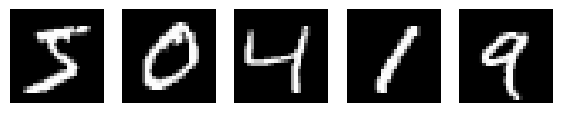

In [6]:
plt.figure(figsize=(7, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

---
## Model

A vision transformer (ViT) model for classifying MNIST digits

In [17]:
config = dict(
    embed_dim     = 32,      # Embedding dimension
    num_blocks    = 4,       # Number of transformer blocks
    num_heads     = 4,       # Number of attention heads
    dropout       = 0.1,     # Dropout for transformer blocks
    ff_dim        = 64,      # Feed-forward layer dimensionality
    pre_layernorm = True,    # Use pre-layernormalization
    patch_size = x_train.shape[1] // 4,

    optimizer = "nadam",
    learning_rate = 1e-4
)

In [24]:
run = wandb.init(project="mnist_vit", config=config)

In [25]:
y = x = tf.keras.layers.Input((x_train.shape[1:])) # (28, 28)
y = tf.keras.layers.Reshape((*x_train.shape[1:], 1))(y) # (28, 28, 1)

# Image patches
y = tf.keras.layers.Conv2D(
    filters=config["embed_dim"],
    kernel_size=config["patch_size"],
    strides=config["patch_size"])(y)
y = tf.keras.layers.Reshape((-1, config["embed_dim"]))(y)

# Position embeddings
y = common.FixedPositionEmbedding(y.shape[1], config["embed_dim"])(y)

# Transformer blocks
for _ in range(config["num_blocks"]):
    y = common.TransformerBlock(
        embed_dim=config["embed_dim"],
        num_heads=config["num_heads"],
        ff_dim=config["ff_dim"],
        prenorm=config["pre_layernorm"],
        dropout_rate=config["dropout"])(y)

# Pooling and output
y = tf.keras.layers.GlobalAveragePooling1D()(y)
y = tf.keras.layers.Dense(config["embed_dim"], activation='gelu')(y)
y = tf.keras.layers.Dense(10, activation="softmax")(y)

model = tf.keras.Model(x, y)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape_4 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          1600      
                                                                 
 reshape_5 (Reshape)         (None, 16, 32)            0         
                                                                 
 fixed_position_embedding_2   (None, 16, 32)           512       
 (FixedPositionEmbedding)                                        
                                                                 
 transformer_block_6 (Transf  (None, 16, 32)           21120     
 ormerBlock)                                               

In [26]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = common.select_optimizer(config["optimizer"])(config["learning_rate"]),
    metrics = tf.keras.metrics.SparseCategoricalAccuracy())

---
## Model Training

In [27]:
wandb_callback = wandb.keras.WandbCallback()
wandb_callback.save_model_as_artifact = False

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [28]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[wandb_callback]
)

Epoch 1/10
469/469 [==============================] - 13s 18ms/step - loss: 1.2908 - sparse_categorical_accuracy: 0.5608 - val_loss: 0.7897 - val_sparse_categorical_accuracy: 0.7367
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.5822 - val_sparse_categorical_accuracy: 0.8137
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5369 - sparse_categorical_accuracy: 0.8267 - val_loss: 0.4525 - val_sparse_categorical_accuracy: 0.8568
Epoch 4/10
469/469 [==============================] - 8s 17ms/step - loss: 0.4345 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.3520 - val_sparse_categorical_accuracy: 0.8885
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.3568 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.2891 - val_sparse_categorical_accuracy: 0.9116
Epoch 6/10
469/469 [==============================] - 8s 18ms/step - loss: 0.3009 - sparse_cat

In [31]:
model.save(os.path.join(run.dir, "mnist_vit"))

INFO:tensorflow:Assets written to: /home/dwl2x/Research/Seminar/wandb/run-20230213_235901-g7we3zg0/files/mnist_vit/assets


INFO:tensorflow:Assets written to: /home/dwl2x/Research/Seminar/wandb/run-20230213_235901-g7we3zg0/files/mnist_vit/assets


In [32]:
run.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▁▁▁▁
sparse_categorical_accuracy,▁▅▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▇▇▇███
best_epoch,9
best_val_loss,0.16721
epoch,9
loss,0.1949
sparse_categorical_accuracy,0.93882
val_loss,0.16721


---
## Results

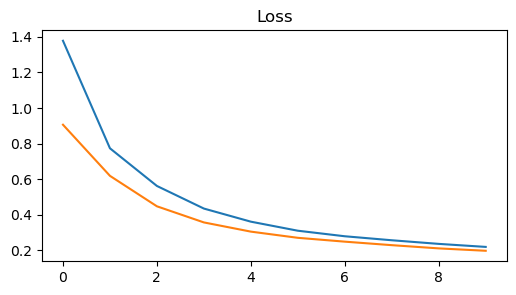

In [14]:
plt.figure(figsize=(6, 3))
plt.title("Loss")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.show()

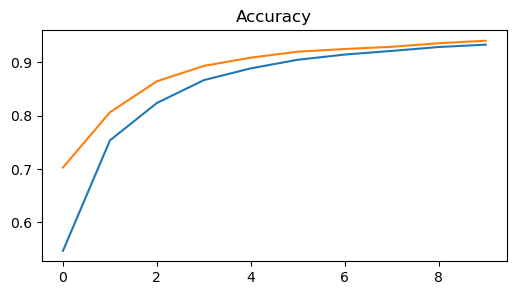

In [15]:
plt.figure(figsize=(6, 3))
plt.title("Accuracy")
plt.plot(history.history["sparse_categorical_accuracy"], label="Training")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="Validation")
plt.show()